## Praca domowa 3



In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
import random

In [ ]:
random.seed(4320549)

1. Wybranie funkcji dyskryminacyjnej, stałej uczenia, liczby neutronów.

In [ ]:
def GeLU(x):
    return 0.5 * x * (1 + erf(x / np.sqrt(2)))

In [ ]:
eps = 0.0001
H = 15

Napisz funkcję forward(x, w, alpha, theta)

In [ ]:
def forward(X, w = w, alpha=alpha, theta=theta):
    return np.sum(alpha[:, None] * GeLU(w[:, None] * X[None, :] + theta[:, None]), axis=0)

Napisz funkcję function_factory

In [ ]:
def function_factory(w, alpha, theta):
    def forward2(x):
        return forward(x, w, alpha, theta)
    return forward2

Wylosuj początkowe wartości w, alpha, theta

In [ ]:
scale = np.sqrt(2/H)
w     = np.random.normal(scale=scale, size=H)
alpha = np.random.normal(scale=scale, size=H)
theta = np.random.normal(scale=scale, size=H)

Wygeneruj N=100 obserwacji treningowych z modelu Y = f(X) + eps

In [ ]:
def f(x):
    return (np.sin(12*(x+0.2))) / (x+0.2)

In [ ]:
N = 100
X1 = np.random.uniform(-0.8, 0.2, N//2)
X2 = np.random.uniform( 1.0, 2.0, N - N//2)
X = np.concatenate([X1, X2])
eps_i = np.random.normal(scale=1.0, size=N)

Y = f(X) + eps_i

Napisz funkcję IMSE

In [ ]:
def IMSE(g, a=-1, b=2, M=1000):
    x_s = np.linspace(a, b, M)
    errors_sq = (g(x_s) - f(x_s))**2
    return np.trapezoid(errors_sq, x_s)

Napisz funkcję MSE

In [ ]:
def MSE(X, Y, w, alpha, theta):
    return np.mean((forward(X, w, alpha, theta) - Y)**2)

Napisz funkcję grad_w(), grad_alpha(), grad_theta()

In [ ]:
def GeLU_d(z):
    Phi = 0.5 * (1 + erf(z / np.sqrt(2)))
    phi = (1 / np.sqrt(2*np.pi)) * np.exp(-z**2 / 2)
    return Phi + z * phi

In [ ]:
def grad_alpha(X, Y, w, alpha, theta):
    # ∂MSE/∂α_j = (2/N) * sum_i e_i * σ(w_j x_i + θ_j)
    N = X.shape[0]
    Z = w[:, None] * X[None, :] + theta[:, None]
    errors = np.sum(alpha[:, None] * GeLU(Z), axis=0)  - Y
    return (2/N) * np.sum(errors[None, :] * GeLU(Z), axis=1)

In [ ]:
def grad_w(X, Y, w, alpha, theta):
    #∂MSE/∂w_j = (2/N) * sum_i e_i * α_j * σ'(w_j x_i + θ_j) * x_i
    N = X.shape[0]
    Z = w[:, None] * X[None, :] + theta[:, None]
    errors = np.sum(alpha[:, None] * GeLU(Z), axis=0) - Y
    return (2/N) * np.sum(errors[None, :] * alpha[:, None] * GeLU_d(Z) * X[None, :], axis=1)

In [ ]:
def grad_theta(X, Y, w, alpha, theta):
    # ∂MSE/∂θ_j = (2/N) * sum_i e_i * α_j * σ'(w_j x_i + θ_j)
    N = X.shape[0]
    Z = w[:, None] * X[None, :] + theta[:, None]
    errors = np.sum(alpha[:, None] * GeLU(Z), axis=0) - Y
    return (2/N) * np.sum(errors[None, :] * (alpha[:, None] * GeLU_d(Z)), axis=1)

Aktualizacja wektorów w, alpha, theta

In [ ]:
w1 = w - grad_w(X,Y, w, alpha, theta) * eps
theta1 = theta - grad_theta(X,Y, w, alpha, theta)*eps
alpha1 = alpha - grad_theta(X,Y, w, alpha, theta)*eps
eps1 = eps

Policz MSE na zbiorze treningowym

In [ ]:
MSE(X, Y, w1, alpha1, theta1)

Powtarzaj kroki 11 i 12 aż do zbieżności MSE

In [ ]:
MSE_history = []
for it in range(20000):
    w_d = grad_w(X, Y, w1, alpha1, theta1)
    alpha_d = grad_alpha(X, Y, w1, alpha1, theta1)
    theta_d = grad_theta(X, Y, w1, alpha1, theta1)
    w1     -= eps1 * w_d
    alpha1 -= eps1 * alpha_d
    theta1 -= eps1 * theta_d

    loss = MSE(X, Y, w1, alpha1, theta1)
    MSE_history.append(loss)

    if it > 0 and MSE_history[-1] > MSE_history[-2]:
        eps1 /= 10
    if it > 0:
        prev, curr = MSE_history[-2], MSE_history[-1]
        if prev - curr < 1e-2:
            eps1 *= 1.2
        if abs(prev - curr)< 1e-6:
            break
    print(f"Iter {it}, MSE={loss:.6f}")

Porównanie wartości MSE vs iteracja

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(MSE_history, label='MSE')
plt.xlabel('Iteracja')
plt.ylabel('MSE')
plt.title('MSE vs Iteracja')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Wnioski: Na wykresie widać dwie wyraźne fazy uczenia: bardzo szybki spadek MSE z około 25 do około 3 w pierwszych 1 400 iteracjach, a następnie łagodniejsze, niemal liniowe obniżanie błędu aż do wartości około 1 w okolicach 5 000 iteracji. Dla pojedynczych iteraacji pojawiają się "skoki", jednak nie są one gwałtowne, dzięki odpowiedniej adaptacji kroku. Wartości MSE dla tej sieci zbiegają do niskiej (1.010768) wartości MSE.

Wartość IMSE - 1. nauczona sieć

In [ ]:
IMSE_siec = IMSE(function_factory(w, alpha, theta))

Porównanie wartości IMSE - 2. smoothing splines

In [ ]:
idx = np.argsort(X)
x_sorted = X[idx]
y_sorted = Y[idx]

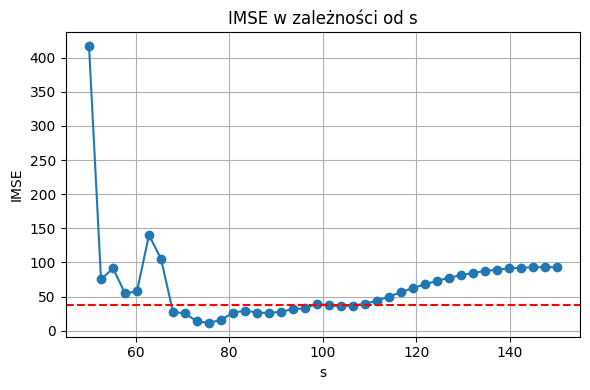

In [488]:
plt.show()
s_values_big = np.linspace(50, 150, 40)
imse_vals = []
for s in s_values_big:
    tck = splrep(x_sorted, y_sorted, s=s)
    g = lambda xx, tck=tck: splev(xx, tck)
    imse_vals.append(IMSE(g))

plt.figure(figsize=(6, 4))
plt.plot(s_values_big, imse_vals, 'o-')
plt.axhline(
    IMSE_siec,
    color='red',
    linestyle='--',
    label='IMSE sieci neuronowej'
)
plt.xlabel('s')
plt.ylabel('IMSE')
plt.title('IMSE w zależności od s');
plt.grid()
plt.tight_layout()
plt.show()

Wnioski: Dla małych wartości s spline próbuje odwzorować każdy szczegół, włącznie z szumem pomiarowym, co prowadzi do przeuczenia. W miarę zwiększania s osiągany jest zakres około 65–80, w którym estymator idealnie równoważy elastyczność i gładkość – błąd IMSE spada wówczas do około 12, co jest znacznie lepszym wynikiem niż ~38 uzyskiwane przez sieć neuronową (czerwona linia). Jednak dalsze podnoszenie s przynosi efekt odwrotny: spline staje się zbyt "sztywny" i IMSE gwałtownie rośnie, przekraczając ostatecznie 90.

Porównanie wartości IMSE - 3. estymator gęstościowy

/var/folders/x3/bn07ssfn4v59ntrzjc4whh6c0000gn/T/ipykernel_93804/318724085.py:3: RuntimeWarning: invalid value encountered in divide
  return (W * y_train).sum(axis=1) / W.sum(axis=1)


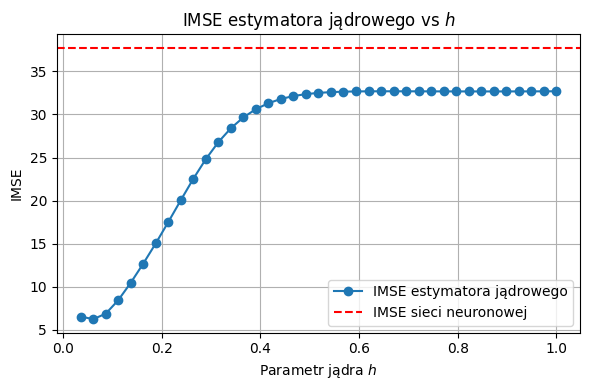

In [491]:
def nadaraya_watson(x_train, y_train, h, x_eval):
    W = np.exp(-0.5*((x_eval[:,None]-x_train[None,:])/h)**2)
    return (W * y_train).sum(axis=1) / W.sum(axis=1)

h_values = np.linspace(0.01, 1, 40)

imse_kernel = []
for h in h_values:
    gk = lambda xx, h=h: nadaraya_watson(x_sorted, y_sorted, h, xx)
    imse_kernel.append(IMSE(gk))

plt.figure(figsize=(6,4))
plt.plot(h_values, imse_kernel, 'o-', label='IMSE estymatora jądrowego')
plt.axhline(
    IMSE_siec,
    color='red',
    linestyle='--',
    label='IMSE sieci neuronowej'
)
plt.xlabel('Parametr jądra $h$')
plt.ylabel('IMSE')
plt.title('IMSE estymatora jądrowego vs $h$')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Wniosek: dla bardzo małych wartości (około 0.01–0.1) estymator jądrowy osiąga minimalne IMSE rzędu ~6, znacznie lepiej niż stały poziom sieci neuronowej (~38). W miarę zwiększania h od ~0.1 wzrasta błąd do około 32–33, a następnie stabilizuje się – efekt zbyt mocnego wygładzania (underfitting). Zatem optymalny wybór h w tym przykładzie leży w wąskim paśmie niskich wartości.

Porównanie wartości IMSE - 4. estymator z regularyzacją Ridge

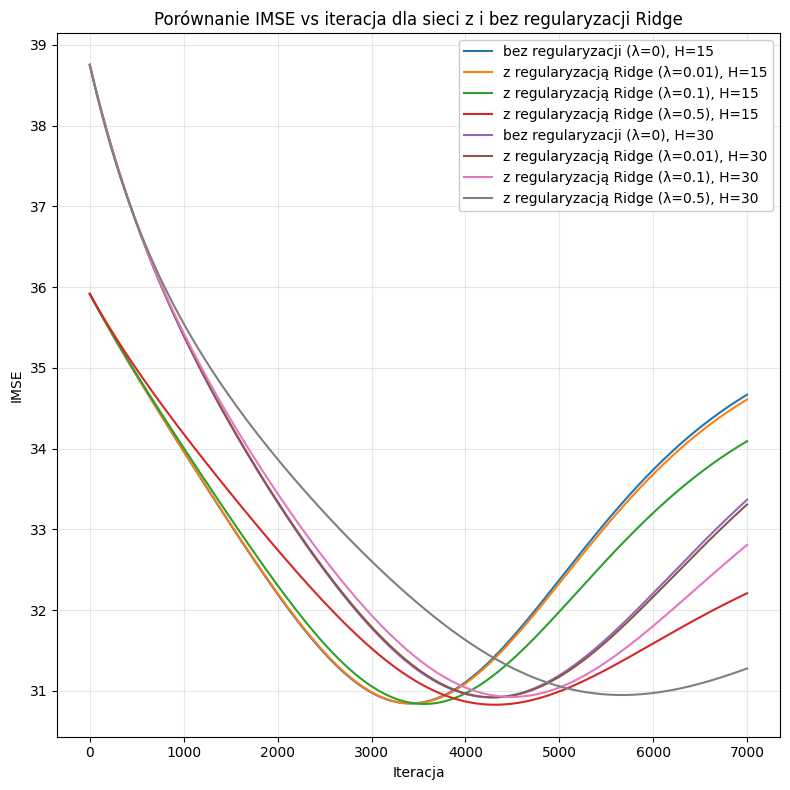

In [506]:
def train_record_imse(X, Y, H=15, eps=1e-4, max_iters=7000, lam=0.0, seed=4320549):
    np.random.seed(seed)
    scale = np.sqrt(2/H)
    w1 = np.random.normal(scale=scale, size=H)
    alpha1 = np.random.normal(scale=scale, size=H)
    theta1 = np.random.normal(scale=scale, size=H)

    imse_history = []
    for it in range(max_iters):
        dw = grad_w(X, Y, w1, alpha1, theta1) + lam * w1
        da = grad_alpha(X, Y, w1, alpha1, theta1) + lam * alpha1
        dt = grad_theta(X, Y, w1, alpha1, theta1) + lam * theta1

        w1 -= eps * dw
        alpha1 -= eps * da
        theta1 -= eps * dt

        g = lambda xx, w=w1, a=alpha1, t=theta1: forward(xx, w, a, t)
        imse_val = IMSE(g)
        imse_history.append(imse_val)

    return imse_history


hist_no_ridge = train_record_imse(X, Y, lam=0.0)
hist_ridge1 = train_record_imse(X, Y, lam=0.01)
hist_ridge2 = train_record_imse(X, Y, lam=0.1)
hist_ridge3 = train_record_imse(X, Y, lam=0.5)

hist_no_ridge30 = train_record_imse(X, Y, H=30, lam=0.0)
hist_ridge1_30 = train_record_imse(X, Y, H=30, lam=0.01)
hist_ridge2_30 = train_record_imse(X, Y, H=30, lam=0.1)
hist_ridge3_30 = train_record_imse(X, Y, H=30, lam=0.5)

plt.figure(figsize=(8,8))
plt.plot(hist_no_ridge, label='bez regularyzacji (λ=0), H=15')
plt.plot(hist_ridge1, label='z regularyzacją Ridge (λ=0.01), H=15')
plt.plot(hist_ridge2, label='z regularyzacją Ridge (λ=0.1), H=15')
plt.plot(hist_ridge3, label='z regularyzacją Ridge (λ=0.5), H=15')
plt.plot(hist_no_ridge30, label='bez regularyzacji (λ=0), H=30')
plt.plot(hist_ridge1_30, label='z regularyzacją Ridge (λ=0.01), H=30')
plt.plot(hist_ridge2_30, label='z regularyzacją Ridge (λ=0.1), H=30')
plt.plot(hist_ridge3_30, label='z regularyzacją Ridge (λ=0.5), H=30')
plt.xlabel('Iteracja')
plt.ylabel('IMSE')
plt.title('Porównanie IMSE vs iteracja dla sieci z i bez regularyzacji Ridge')
plt.legend(loc='best', framealpha=1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Wniosek: Moment najmniejszego IMSE dla prawie wszystkich sposobów przypada w okolicach 3500-4500 iteracji. Za każdym razem jest to podobny poziom - IMSE wynosi około 31. Możemy również wywnioskować, że przy H=15 dopasowywanie modelu jest szybsze, jednak przy bardzo dużej ilości iteracji (mimo, że nie jest to optymalna ilość iteracji) - model przy H=30 osiąga niższe wartości IMSE (możemy wnioskować, że wolniej się przeucza). W ogólności, w obu przypadkach możey stwierdzić, że dla wartości lambda=0.5 osiągane są najgorsze wyniki (poza przypadkiem przy bardzo dużej liczbie iteracji i H=30 - wtedy model z lambda =0.5 jest najlepszy, jednak wynika to stąd, że znacznie wyższa liczba iteracji jest dla niego optymalna (w porównaniu z innymi modelami).

Porównanie wartości IMSE - 5. regularyzacja LASSO

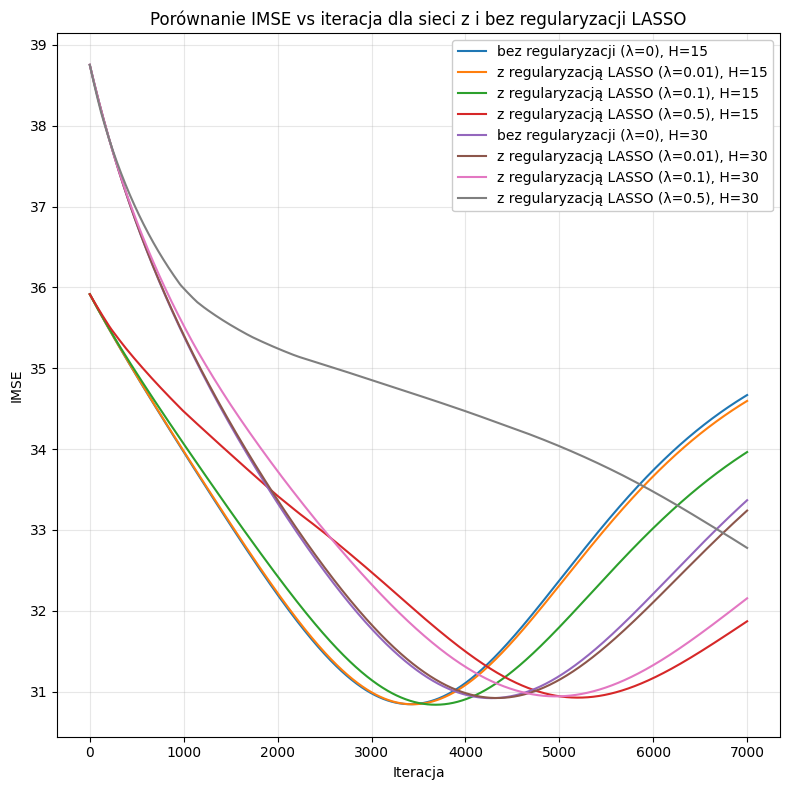

In [510]:
def soft_threshold(u, thresh):
    return np.sign(u) * np.maximum(np.abs(u) - thresh, 0)
def train_record_imse_lasso(X, Y, H=15, eps=1e-4, max_iters=7000, lam=0.0, seed=4320549):
    np.random.seed(seed)
    scale = np.sqrt(2/H)
    w1 = np.random.randn(H) * scale
    alpha1 = np.random.randn(H) * scale
    theta1 = np.random.randn(H) * scale

    imse_history = []
    for it in range(max_iters):
        w_new = w1 - eps * grad_w(X, Y, w1, alpha1, theta1)
        alpha_new = alpha1 - eps * grad_alpha(X, Y, w1, alpha1, theta1)
        theta_new = theta1 - eps * grad_theta(X, Y, w1, alpha1, theta1)



        w1 = soft_threshold(w_new, eps * lam)
        alpha1 = soft_threshold(alpha_new, eps * lam)
        theta1 = soft_threshold(theta_new, eps * lam)

        g = lambda xx, w=w1, a=alpha1, t=theta1: forward(xx, w, a, t)
        imse_val = IMSE(g)
        imse_history.append(imse_val)

    return imse_history


hist_no_lasso = train_record_imse_lasso(X, Y, lam=0.0)
hist_lasso1 = train_record_imse_lasso(X, Y, lam=0.01)
hist_lasso2 = train_record_imse_lasso(X, Y, lam=0.1)
hist_lasso4 = train_record_imse_lasso(X, Y, lam=0.5)

hist_no_lasso30 = train_record_imse_lasso(X, Y, H=30, lam=0.0)
hist_lasso1_30 = train_record_imse_lasso(X, Y, H=30, lam=0.01)
hist_lasso2_30 = train_record_imse_lasso(X, Y, H=30, lam=0.1)
hist_lasso4_30 = train_record_imse_lasso(X, Y, H=30, lam=0.5)

plt.figure(figsize=(8, 8))
plt.plot(hist_no_lasso, label='bez regularyzacji (λ=0), H=15')
plt.plot(hist_lasso1, label='z regularyzacją LASSO (λ=0.01), H=15')
plt.plot(hist_lasso2, label='z regularyzacją LASSO (λ=0.1), H=15')
plt.plot(hist_lasso4, label='z regularyzacją LASSO (λ=0.5), H=15')
plt.plot(hist_no_lasso30, label='bez regularyzacji (λ=0), H=30')
plt.plot(hist_lasso1_30, label='z regularyzacją LASSO (λ=0.01), H=30')
plt.plot(hist_lasso2_30, label='z regularyzacją LASSO (λ=0.1), H=30')
plt.plot(hist_lasso4_30, label='z regularyzacją LASSO (λ=0.5), H=30')
plt.xlabel('Iteracja')
plt.ylabel('IMSE')
plt.title('Porównanie IMSE vs iteracja dla sieci z i bez regularyzacji LASSO')
plt.legend(loc='best', framealpha=1)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Wnioski: Takie same jak w przypadku regularyzacji Ridge.